<a href="https://colab.research.google.com/github/VilasSonawane/NYCTaxiTimePrediction-Model1/blob/main/Copy_of_Vilas_Copy_of_NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

#<b>Import libraries

In [ ]:
!pip install klib

     |████████████████████████████████| 133 kB 30.2 MB/s 
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.0.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!pip install hyperopt

In [ ]:
from psutil import*

In [ ]:
cpu_count()

2

In [ ]:
!lscpu |grep "Model name"

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import klib 
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score, auc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import datetime as dt
import warnings; warnings.simplefilter('ignore')

#<b>Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#<b>Import Dataset

In [ ]:
# Importing the dataset
path = '/content/drive/My Drive/NYC Taxi Trip Prediction/Data & Resources/NYC Taxi Data.csv'
nyc_taxi = pd.read_csv(path)

In [ ]:
nyc_taxi = pd.read_csv(path)

#<b>Data Overview

In [ ]:
nyc_taxi.shape

In [ ]:
nyc_taxi.head()

In [ ]:
nyc_taxi.info()

In [ ]:
nyc_taxi.describe(include= 'all')

In [ ]:
nyc_taxi.isnull().sum()

In [ ]:
nyc_taxi.nunique()

#<b> Exploratary Data Analysis

##<b>So Lets do Some Exploratary data analysis of dataset  if any inconsitancy somewhere lets deal with that

In [ ]:
#Categorical Data Plot
klib.cat_plot(nyc_taxi)

In [ ]:
# default representation of a distribution plot, other settings include fill_range, histogram, ...
klib.dist_plot(nyc_taxi)

In [ ]:
##Check any NULL records present in our dataset.
klib.missingval_plot(nyc_taxi)

In [ ]:
#Checking number of rows and columns in our dataset.
print("Number of rows is: ", nyc_taxi.shape[0])
print("Number of columns is: ", nyc_taxi.shape[1])

In [ ]:
#Let's look at each feture in our dataset.
nyc_taxi.columns

In [ ]:
#Let us now look at the datatypes of all features.
nyc_taxi.dtypes

In [ ]:
#We have pickup_datetime, dropoff_datetime of the type 'object'. Convert it into type 'datetime'.
nyc_taxi['pickup_datetime'] = pd.to_datetime(nyc_taxi['pickup_datetime'])
nyc_taxi['dropoff_datetime'] = pd.to_datetime(nyc_taxi['dropoff_datetime'])

In [ ]:
nyc_taxi.describe()

#**Feature Creation**
Now, let us extract pickup_datetime and dropoff_datetimeand create Some new features from this datetime features we  have just created.

In [ ]:
#It will contain the day number instead of characters with Monday=0 and Sunday=6.
nyc_taxi['pickup_day']=nyc_taxi['pickup_datetime'].dt.day_name()
nyc_taxi['dropoff_day']=nyc_taxi['dropoff_datetime'].dt.day_name()
#It will convert weekday into number start at Monday=0 and end at Sunday=6.
nyc_taxi['pickup_day_no']=nyc_taxi['pickup_datetime'].dt.weekday
nyc_taxi['dropoff_day_no']=nyc_taxi['dropoff_datetime'].dt.weekday
#Extract hour only from pickup_datetime.
nyc_taxi['pickup_hour']=nyc_taxi['pickup_datetime'].dt.hour
nyc_taxi['dropoff_hour']=nyc_taxi['dropoff_datetime'].dt.hour
#Extract month in number only from pickup_datetime with January=1
nyc_taxi['pickup_month']=nyc_taxi['pickup_datetime'].dt.month
nyc_taxi['dropoff_month']=nyc_taxi['dropoff_datetime'].dt.month

**We have created the following features:**

**pickup_day and dropoff_day** which will contain the name of the day on which the ride was taken.
**pickup_day_no and dropoff_day_n**o which will contain the day number instead of characters with Monday=0 and Sunday=6.
**pickup_hour and dropoff_hour** with an hour of the day in the 24-hour format.
**pickup_month and dropoff_month** with month number with January=1 and June =06.

We also saw during dataset exploration that we have coordinates in the form of longitude and latitude for pickup and dropoff. But, we can’t really gather any insights or draw conclusions from that.
So, the most obvious feature that we can extract from this is distance. Let us do that.

**Importing the library which lets us calculate distance from geographical coordinates.**

# **Lets Importing the geopy.distance library which will help us calculate distance from geographical coordinates**.

In [ ]:
from geopy.distance import great_circle

In [ ]:
#Creating the function for calculating distance between pickup and dropoff
def cal_distance(pickup_lat,pickup_long,dropoff_lat,dropoff_long):
 
 start_coordinates=(pickup_lat,pickup_long)
 stop_coordinates=(dropoff_lat,dropoff_long)
 
 return great_circle(start_coordinates,stop_coordinates).km

In [ ]:
#Applying the function to our dataset and creating the feature ‘distance’.
nyc_taxi['distance'] = nyc_taxi.apply(lambda x: cal_distance(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude'] ), axis=1)

# **Lets Create New Feature Speed(km/Hr) With help of Distance and Duration Column**

In [ ]:
nyc_taxi['speed'] = (nyc_taxi.distance*3600/(nyc_taxi.trip_duration))

Next,Lets defined a function that lets us determine what time of the day the ride was taken.

We will create four parts of time:-

1.**Morning** (from 6:00 am to 11:59 pm),

2.**Afternoon** (from 12 noon to 3:59 pm),

3.**Evening** (from 4:00 pm to 9:59 pm), and

4.**Late Night** (from 10:00 pm to 5:59 am)

In [ ]:
#Dividing 24 hours into four parts
def time_of_day(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,22):
        return 'Evening'
    else:
        return 'Late night'

In [ ]:
#Now let us apply this function and create new columns in the dataset.
nyc_taxi['pickup_timeofday'] = nyc_taxi['pickup_hour'].apply(time_of_day)
nyc_taxi['dropoff_timeofday']=nyc_taxi['dropoff_hour'].apply(time_of_day)

In [ ]:
nyc_taxi.head()

In [ ]:
#Let us check the data type of all features.
nyc_taxi.dtypes

Now our dataset is complete for the further analysis before we train our model with optimal variables.

#**Univariate Analysis**
The univariate analysis involves studying patterns of all variables individually.

**Target Variable**

Let us start with the target varibale i.e trip duration.
# **1.Trip duration.**

In [ ]:
sns.histplot(nyc_taxi['trip_duration'],kde=False,bins=20)

In [ ]:
sns.boxplot(nyc_taxi['trip_duration'])

In [ ]:
for i in range(0,100,10):
  duration= nyc_taxi['trip_duration'].values
  duration= np.sort(duration, axis= None)
  print("{} percentile value is {}".format(i, duration[int(len(duration)*(float(i)/100))]))
print("100 percentile value is ",duration[-1])

In [ ]:
for i in range(90,100):
  duration= nyc_taxi['trip_duration'].values
  duration= np.sort(duration, axis= None)
  print("{} percentile value is {}".format(i, duration[int(len(duration)*(float(i)/100))]))
print("100 percentile value is ",duration[-1])

In [ ]:
nyc_taxi['trip_duration'].sort_values(ascending =False)

In [ ]:
for i in range(0,10):
  duration= nyc_taxi['trip_duration'].values
  duration= np.sort(duration, axis= None)
  print("{} percentile value is {}".format(i, duration[int(len(duration)*(float(i)/100))]))
print("100 percentile value is ",duration[-1])

## **We can see that there are some entries  which are significantly different from others.As there are four rows only, let us drop this row.**

In [ ]:
# Setting Trip duration upper limit
nyc_taxi = nyc_taxi[nyc_taxi.trip_duration <= 3440]


In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(nyc_taxi['trip_duration'])
plt.xlabel('Trip Duration')
plt.show()

This histogram shows right skewness, hence let's apply the log10 to transform it to the normal distribution.

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(np.log10(nyc_taxi['trip_duration'])) #taking log of trip_duration
plt.xlabel('Trip Duration')
plt.show()

* Here, we can see that trip_duration is normally distributed.
* There are some outliers. Lets see the boxplot of this variable.

In [ ]:
plt.figure(figsize = (10,5))
sns.boxplot(nyc_taxi.trip_duration)
plt.xlabel('Trip Duration')
plt.show()

We can clearly see an outlier and should be removed for the data consistency.

Calclating 0-100th percentille to find a correct percentile value for removal of outliers.

The 90th percentile i.e. 1634 looks reasonable. But, 100th percentile i.e. 3526282 is outlier. Hence removing these would be a better idea.

Let's expand from 90th percentile to 100th percentile as to look further for the 99th percentile.

**Let's visualize the number of trips taken in diifferent slabs of ... secconds respectively**

In [ ]:
plt.figure(figsize = (10,5))
nyc_taxi.trip_duration.groupby(pd.cut(nyc_taxi.trip_duration, np.arange(1,90000,5000))).count().plot(kind='bar')
plt.xlabel('Trip Duration Slots in Second')
plt.ylabel('Trip Counts)')
plt.show()

In [ ]:
plt.figure(figsize = (10,5))
nyc_taxi.trip_duration.groupby(pd.cut(nyc_taxi.trip_duration, np.arange(5000,90000,5000))).count().plot(kind='bar')
plt.xlabel('Trip Duration Slots in Second')
plt.ylabel('Trip Counts)')
plt.show()

In [ ]:
plt.figure(figsize = (10,5))
nyc_taxi.trip_duration.groupby(pd.cut(nyc_taxi.trip_duration, np.arange(1,5000,500))).count().plot(kind='bar')
plt.xlabel('Trip Duration Slots in Second')
plt.ylabel('Trip Counts')
plt.show()

In [ ]:
plt.figure(figsize = (10,5))
nyc_taxi.trip_duration.groupby(pd.cut(nyc_taxi.trip_duration, np.arange(0,600,60))).count().plot(kind='bar')
plt.xlabel('Trip Duration Slots in Second')
plt.ylabel('Trip Counts')
plt.show()

In [ ]:
plt.figure(figsize = (10,5))
nyc_taxi.trip_duration.groupby(pd.cut(nyc_taxi.trip_duration, np.arange(0,61,5))).count().plot(kind='bar')
plt.xlabel('Trip Duration Slots in Second')
plt.ylabel('Trip Counts')
plt.show()

Let's have a look at the 10 largest and smallest value of trip_duration.

We can see that major chunk (99th percentile) of trip duration is completed in 3440 seconds i.e. nearly 1 hour.

There are very few trip which have duration greater than 5000 seconds.

There are some durations with as low as 1 second. which points towards trips with 0 km distance.

We should get rid the outliers for the sake of data consistency. (Trip duration greater than 5000 seconds and also trip duration less than 30 seconds)

# **2.Pickup_timeofday & Dropoff_timeofday**

In [ ]:
figure,(ax3,ax4)=plt.subplots(ncols=2,figsize=(20,5))
ax3.set_title('Pickup Time of Day')
ax=sns.countplot(x="pickup_timeofday",data=nyc_taxi,ax=ax3)
ax4.set_title('Dropoff Time of Day')
ax=sns.countplot(x="dropoff_timeofday",data=nyc_taxi,ax=ax4)

As we saw above, evenings are the busiest.

# <b>3. Vendor id

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(nyc_taxi.vendor_id)
plt.xlabel('Vendor ID')
plt.ylabel('Count')
plt.show()

We see that there is not much difference between the trips taken by both vendors.

# <b>4. Passenger count

In [ ]:
no_of_passenger = nyc_taxi['passenger_count'].value_counts().reset_index()
no_of_passenger.rename(columns={'index':'no_of_passenger', 'passenger_count':'trip_counts'})


In [ ]:
#Removing 0 and more than 6 passenger 
nyc_taxi = nyc_taxi[nyc_taxi['passenger_count'] != 0]
nyc_taxi = nyc_taxi[nyc_taxi['passenger_count']<=6]

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(x='passenger_count',data=nyc_taxi)
plt.ylabel('Count')
plt.xlabel('No.of Passngers')
plt.show()

Let us remove the rows which have 0, 8 and 9 passenger count

* We see the highest amount of trips was taken by a single passenger.
* The instance of large group of people travelling together is rare.

# <b>5.Store and Forward Flag

In [ ]:
nyc_taxi['store_and_fwd_flag'].value_counts(normalize=True)

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(x='store_and_fwd_flag',data=nyc_taxi)
plt.ylabel('Count')
plt.xlabel('store_and_fwd_flag')
plt.show()

* We can see that only about 1% of the trip details were stored in the vehicle memory first before sending it to the server.

* This might have occured because of the GPS or mobile device battery was down when the trip finished.

# <b>6.Distance

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(nyc_taxi['distance'])
plt.xlabel('distance')
plt.show()

In [ ]:
nyc_taxi['distance'].value_counts().sort_values(ascending  =True)

In [ ]:
#Removing  entries which are having distance less than 50 metere
nyc_taxi = nyc_taxi[nyc_taxi['distance'] > 0.05]

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(np.log10(nyc_taxi['distance']))
plt.xlabel('distance')
plt.show()

In [ ]:
plt.figure(figsize = (10,5))
nyc_taxi.distance.groupby(pd.cut(nyc_taxi.distance, np.arange(0,1200,100))).count().plot(kind='bar')
plt.xlabel('Trip distance Slots in km')
plt.ylabel('Trip Counts')
plt.show()

In [ ]:
plt.figure(figsize = (10,5))
nyc_taxi.distance.groupby(pd.cut(nyc_taxi.distance, np.arange(100,1001,100))).count().plot(kind='bar')
plt.xlabel('Trip distance Slots in km')
plt.ylabel('Trip Counts')
plt.show()

In [ ]:
plt.figure(figsize = (10,5))
nyc_taxi.distance.groupby(pd.cut(nyc_taxi.distance, np.arange(0.5,10.1,0.5))).count().plot(kind='bar')
plt.xlabel('Trip distance Slots in km')
plt.ylabel('Trip Counts')
plt.show()

In [ ]:
plt.figure(figsize = (10,5))
nyc_taxi.speed.groupby(pd.cut(nyc_taxi.distance, np.arange(0,1.05,0.05))).count().plot(kind='bar')
plt.xlabel('Trip distance Slots in km')
plt.ylabel('Trip Counts')
plt.show()

In [ ]:
nyc_taxi[nyc_taxi['distance']>100].value_counts()

In [ ]:
#Removing the rows which are having distance  More than 100 km
nyc_taxi = nyc_taxi[nyc_taxi['distance'] <= 100]

In [ ]:
nyc_taxi.distance.max()

* There are **16 trips with more than 100 km** distance.
* There are **5887 trips with 0 km** distance. so this trip will unneccsary infuence our model that we are droping this rows

**The possible reasons for 0 km trips can be:**

* The dropoff location couldn’t be tracked.
* The driver deliberately took this ride to complete a target ride number.
* The passengers or driver cancelled the trip due to some issue.
* Due to some technical issue in software, etc.

In [ ]:
nyc_taxi.shape

# <b>7.Speed

In [ ]:
nyc_taxi.speed.max()

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(nyc_taxi['speed'])
plt.xlabel('Speed (km/hr)')
plt.show()

In [ ]:
nyc_taxi.speed.max()

In [ ]:
nyc_taxi[nyc_taxi['speed']>105].count()

So At Some Places Speed of the taxi is quite high its from **200 to 9274** So which is unresonble.

1.So it may be because of Some pasemger they might have canceled trip in between on  the way after traveling some distance.
2.The dropoff location couldn’t be tracked.
3.The passengers or driver cancelled the trip due to some issue.
4.Due to some technical issue in software, etc.

so in order to have consitant data **lets drop the rows which have speed more than 200 km/hr.** 

In [ ]:
nyc_taxi = nyc_taxi[nyc_taxi['speed']<=200]

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(nyc_taxi['speed'])
plt.xlabel('Speed (km/hr)')
plt.show()

Let's plot the boxplot for better understanding.

There are trips that were done at a speed of over 100 km/h.

As per the rule in NYC, the speed limit is 25 mph(approx. 40km/h) in New York City.

Let's take a look at the speed range ditribution with the help of graph.

# **Mostly trips are done at a speed range of 5-25 km/hr.**

# <b>8.Pickup_hour & Dropup_hour

In [ ]:
figure,(ax3,ax4)=plt.subplots(ncols=2,figsize=(20,5))
ax3.set_title('Pickup Time of Day (24hr format)')
ax=sns.countplot(x="pickup_hour",data=nyc_taxi,ax=ax3)
ax4.set_title('Dropoff Time of Day (24hr format)')
ax=sns.countplot(x="dropoff_hour",data=nyc_taxi,ax=ax4)

We see the busiest hours are 6:00 pm to 7:00 pm which makes sense as this is the time for people to return home from work.

# <b> 9. Pickup_day & Dropup_day

In [ ]:

figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Pickup Days')
ax=sns.countplot(x="pickup_day",data=nyc_taxi,ax=ax1)
ax2.set_title('Dropoff Days')
ax=sns.countplot(x="dropoff_day",data=nyc_taxi,ax=ax2)

We see Fridays are the busiest days followed by Saturdays. That is probably because it’s weekend.

# **10.Pickup_month & Dropup_month**

In [ ]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Pickup Months (Jan=1 to June=6)')
ax=sns.countplot(x="pickup_month",data=nyc_taxi,ax=ax1)
ax2.set_title('Dropoff Months (Jan=1 to June=6)')
ax=sns.countplot(x="dropoff_month",data=nyc_taxi,ax=ax2)

There is not much difference in the number of trips across months.

#<b>Bivariate Analysis

1.Trip Duration per Vendor

In [ ]:
plt.figure(figsize = (10,5))
sns.barplot(y='trip_duration',x='vendor_id',data=nyc_taxi,estimator=np.mean)
plt.xlabel('Vendor ID')
plt.ylabel('Trip Duration')
plt.show()

There is no difference beteen  vendor 1 and 2

<b>2.Trip Duration per Store and Forward Flagt

In [ ]:
plt.figure(figsize = (10,5))
sns.catplot(y='trip_duration',x='store_and_fwd_flag',data=nyc_taxi,kind='strip')
plt.xlabel('Store and Forward Flag')
plt.ylabel('Duration (seconds)')
plt.show()

So from the above graph we can come to know that mostely long trips data havent store on server.

<b>3.Trip Duration per hour

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(x='pickup_hour',y='trip_duration',data=nyc_taxi)
plt.xlabel('Time of Pickup (24hr format)')
plt.ylabel('Duration (seconds)')
plt.show()

* We see the trip duration is the maximum around 3 pm which may be because of traffic on the roads.
* Trip duration is the lowest around 6 am as streets may not be busy.

<b>4.Trip duration per weekday

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(x='pickup_day_no',y='trip_duration',data = nyc_taxi)
plt.ylabel('Duration (seconds)')
plt.xlabel('')
plt.show()

Trip duration on thursday is longest among all days.


<b>5.Trip duration per month

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(x='pickup_month',y='trip_duration', data = nyc_taxi)
plt.ylabel('Duration (seconds)')
plt.xlabel('Month of Trip ')
plt.show()

* From February, we can see trip duration rising every month.
* There might be some seasonal parameters like wind/rain which can be a factor of this gradual increase in trip duration over a period.


<b>6.Distance and Hour

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(y='distance',x='pickup_hour',data=nyc_taxi)
plt.ylabel('Distance')
plt.xlabel('Pickup Hour')
plt.show()

* Trip distance is highest during early morning hours.
* It is fairly equal from morning till the evening varying around 3 - 3.5 kms.
* It starts increasing gradually towards the late night hours starting from evening till 5 AM and decrease steeply towards morning.


**7.Passenger_count and Trip Duration**

In [ ]:

sns.catplot(y='trip_duration',x='passenger_count',data=nyc_taxi,kind='strip')


<b>8.Distance and Trip Duration

In [ ]:
plt.figure(figsize = (10,5))
plt.scatter(x='trip_duration', y='distance',data=nyc_taxi)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.show()


**9.Passenger_count and Distance**

In [ ]:
sns.catplot(y='distance',x='passenger_count',data=nyc_taxi,kind='strip')

**We see some of the longer distances are covered by either 1 or 2 or 4 passenger rides.**

In [ ]:
# Distance per month
sns.lineplot(x='pickup_month',y='distance',data= nyc_taxi)

In [ ]:
# Distance and Store and Forward Flag
sns.catplot(y='distance',x='store_and_fwd_flag',data=nyc_taxi,kind='strip')

Initially there is some proper correlation between the distance covered and the trip duration in the graph, but later on it seems a little uncorrelated.

We should remove those trips which covered 0 km distance.

The straight line shows some linear relation between the two.

#<b>Correlation Analysis

In [ ]:
klib.corr_plot(nyc_taxi)

#<b>Feature Engineering

**One Hot Encoding**

Dummify features like 'store_and_fwd_flag', and 'pickup_weekday'.

In [ ]:
nyc_taxi.head(2)

In [ ]:
# One hot encoding
nyc_taxi = pd.get_dummies(nyc_taxi, columns=["store_and_fwd_flag", "pickup_timeofday","dropoff_timeofday"], prefix=["store", "pickup","dropoff"])

In [ ]:
plt.figure(figsize=(20,12))
correlation = nyc_taxi.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

In [ ]:
df_corr = nyc_taxi.copy()
df_corr.drop(['id','speed','trip_duration'],axis=1,inplace=True)

In [ ]:
plt.figure(figsize=(20,12))
correlation = df_corr.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

In [ ]:
# Lets Drop he features which are havinh high colinearioty with each other ( More than 0.4)
df_corr.drop(['dropoff_Afternoon','dropoff_Evening', 'dropoff_Late night', 'dropoff_Morning','pickup_longitude', 
              'dropoff_latitude','store_Y','store_N','dropoff_day_no', 'pickup_hour','pickup_Evening','pickup_Morning','dropoff_month','dropoff_hour'],axis=1,inplace=True)

In [ ]:
plt.figure(figsize=(20,12))
correlation = df_corr.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

In [ ]:
df_corr['trip_duration'] = nyc_taxi['trip_duration']

In [ ]:
plt.figure(figsize=(20,12))
correlation = df_corr.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

In [ ]:
independent_variables=['vendor_id', 'passenger_count',
       'dropoff_longitude', 'pickup_latitude',
       'pickup_day_no', 'pickup_month', 'distance',
       'pickup_Afternoon', 'pickup_Late night']

In [ ]:
# Create the data of independent variables
X = df_corr[independent_variables]

# Create the dependent variable data
y = df_corr['trip_duration']

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [ ]:
# Transforming data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
X[0:2]

#<b>Splitting the data in train and test sets

In [ ]:
#Importing RFE and Linear Regression 
from sklearn.model_selection import train_test_split

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Splited the selected data set in 70-30 split for training and testing purpose respectively

In [ ]:
print('Train Data Shape')
print(X_train.shape)
print(y_train.shape)
print('\n')
print('Test Data Shape')
print(X_test.shape)
print(y_test.shape)

Train Data Shape
(1002901, 9)
(1002901,)


Test Data Shape
(429815, 9)
(429815,)


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#<b>Linear Regression

In [ ]:
# Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
linear_reg =  LinearRegression()

#Aplly model on train dataset
linear_reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
#model score on train dataset
linear_reg.score(X_train, y_train)

0.5906774665586653

In [ ]:
#predicted value of train and test dataset
y_pred_train = linear_reg.predict(X_train)
y_pred_test = linear_reg.predict(X_test)

In [ ]:
#Train Data Evaluation Metrics 
lr_train_mse  = mean_squared_error((y_train), (y_pred_train))
print("Train MSE :" , lr_train_mse)

lr_train_r2 = r2_score((y_train), (y_pred_train))
print("Train R2 :" ,lr_train_r2) 

lr_train_r2_ = 1-(1-r2_score((y_train), (y_pred_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ",lr_train_r2_)

Train MSE : 134941.59275596906
Train R2 : 0.5906774665586653
Train Adjusted R2 :  0.5906737932753264


In [ ]:
lr_test_mse  = mean_squared_error((y_test), (y_pred_test))
print("Test MSE :" , lr_test_mse)

lr_test_r2 = r2_score((y_test), (y_pred_test))
print("Test R2 :" ,lr_test_r2)

lr_test_r2_ = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ",lr_test_r2_)

Test MSE : 136348.41671735494
Test R2 : 0.5879876518591438
Test Adjusted R2 :  0.5879790244324427


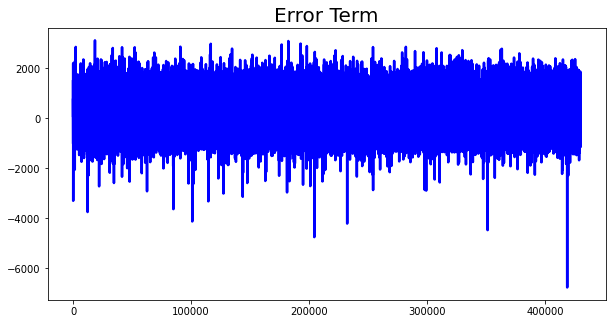

In [ ]:
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error Term', fontsize=20)
plt.show()

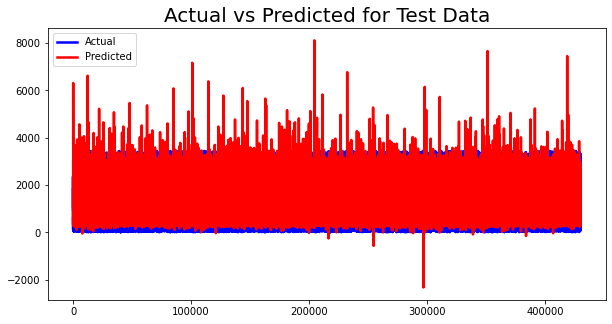

In [ ]:
#Actual vs Prediction
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='blue', linewidth=2.5, linestyle='-')
plt.plot(c, y_pred_test, color='red', linewidth=2.5, linestyle='-')
plt.title('Actual vs Predicted for Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

As we can clearly see the Linear regression model does not provide us with high accuracy. It has high prediction error on the metrics we tested.

#<b>Running Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
#Cross validation
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='r2', cv=5)

In [ ]:
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             scoring='r2')

In [ ]:
print('The best fit alpha value is found out to be :', lasso_regressor.best_params_)
print('The R2 score using the same alpha is :', lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 0.001}
The R2 score using the same alpha is : 0.5906509345538512


**The best parameters for the LASSO Regression which we already tested before to save time when running it again.**
* The best fit alpha value is found out to be : {'alpha': 0.0001}

In [ ]:
lasso_regressor.score(X_train, y_train)

0.5906774665222962

In [ ]:
y_pred_lasso_train = lasso_regressor.predict(X_train)
y_pred_lasso_test = lasso_regressor.predict(X_test)

#<b>Model Evaluation

In [ ]:
lasso_train_mse  = mean_squared_error(y_train, y_pred_lasso_train)
print("Train MSE :" , lasso_train_mse)

lasso_train_r2 = r2_score(y_train, y_pred_lasso_train)
print("Train R2 :" ,lasso_train_r2)

lasso_train_r2_= 1-(1-r2_score(y_train, y_pred_lasso_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", lasso_train_r2)

Train MSE : 134941.59276795888
Train R2 : 0.5906774665222962
Train Adjusted R2 :  0.5906774665222962


In [ ]:
lasso_test_mse  = mean_squared_error(y_test, y_pred_lasso_test)
print("Test MSE :" , lasso_test_mse)

lasso_test_r2 = r2_score(y_test, y_pred_lasso_test)
print("Test R2 :" ,lasso_test_r2)

lasso_test_r2_= 1-(1-r2_score(y_test, y_pred_lasso_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", lasso_test_r2_)

Test MSE : 136348.4103072988
Test R2 : 0.5879876712288024
Test Adjusted R2 :  0.5879790438025068


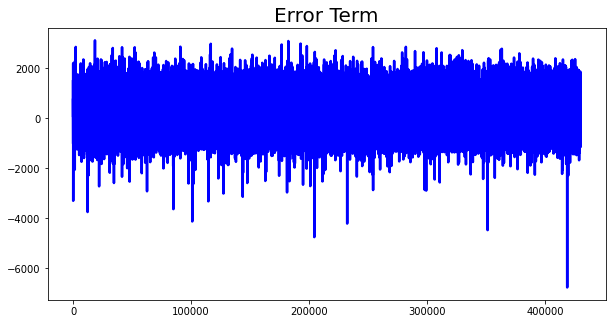

In [ ]:
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_lasso_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error Term', fontsize=20)
plt.show()

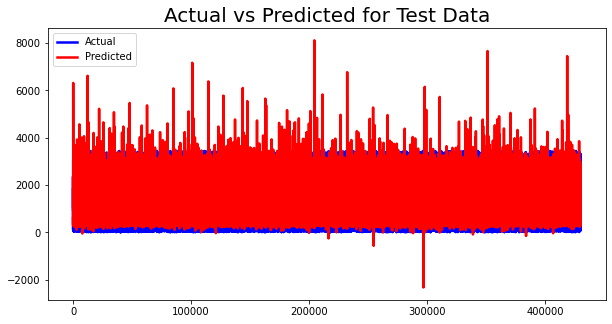

In [ ]:
#Actual vs Prediction
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='blue', linewidth=2.5, linestyle='-')
plt.plot(c, y_pred_lasso_test, color='red', linewidth=2.5, linestyle='-')
plt.title('Actual vs Predicted for Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

The Lasso regresion model doesn't improve on the Linear model either.

#<b>Running Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
#Cross validation
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='r2', cv=5)
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             scoring='r2')

In [ ]:
print('The best fit alpha value is found out to be :' ,ridge_regressor.best_params_)
print('The R2 score using the same alpha is :', ridge_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 40}
The R2 score using the same alpha is : 0.5906509366023351


**The best parameters for the RIDGE Regression which we already tested before to save time when running it again.**
* The best fit alpha value is found out to be : {'alpha': 0.01}

In [ ]:
ridge_regressor.score(X_train, y_train)

0.5906774650769

In [ ]:
y_pred_ridge_train=ridge_regressor.predict(X_train)
y_pred_ridge_test = ridge_regressor.predict(X_test)

#<b>Model Evaluation

In [ ]:
ridge_train_mse  = mean_squared_error(y_train, y_pred_ridge_train)
print("Train MSE :" , ridge_train_mse)

ridge_train_r2 = r2_score(y_train, y_pred_ridge_train)
print("Train R2 :" ,ridge_train_r2)

ridge_train_r2_= 1-(1-r2_score(y_train, y_pred_ridge_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", ridge_train_r2)

Train MSE : 134941.59324446347
Train R2 : 0.5906774650769
Train Adjusted R2 :  0.5906774650769


In [ ]:
ridge_test_mse  = mean_squared_error(y_test, y_pred_ridge_test)
print("Test MSE :" , ridge_test_mse)

ridge_test_r2 = r2_score(y_test, y_pred_ridge_test)
print("Test R2 :" ,ridge_test_r2)

ridge_test_r2_= 1-(1-r2_score(y_test, y_pred_ridge_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", ridge_test_r2_)

Test MSE : 136348.38886894388
Test R2 : 0.5879877360103903
Test Adjusted R2 :  0.5879791085854513


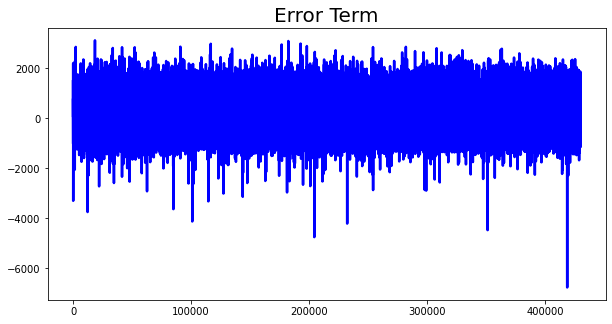

In [ ]:
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_ridge_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error Term', fontsize=20)
plt.show()

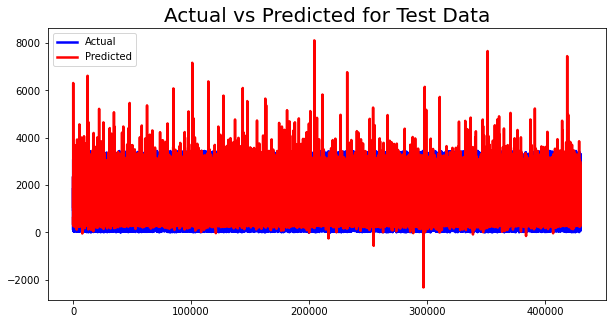

In [ ]:
#Actual vs Prediction
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='blue', linewidth=2.5, linestyle='-')
plt.plot(c, y_pred_ridge_test, color='red', linewidth=2.5, linestyle='-')
plt.title('Actual vs Predicted for Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

The Ridge regresion model doesn't improve on the Linear model either.

#<b>Running Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Create the data of independent variables
X = df_corr[independent_variables]
# Create the dependent variable data
y = df_corr['trip_duration']

In [ ]:
#Lets split The dataset
from sklearn.model_selection import train_test_split

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
X_train[0:2]

,vendor_id,passenger_count,dropoff_longitude,pickup_latitude,pickup_day_no,pickup_month,distance,pickup_Afternoon,pickup_Late night
123196,2,1,-73.972099,40.786568,4,2,3.066331,1,0
1398430,2,1,-73.971725,40.751602,1,2,0.728800,0,0


In [ ]:
# Maximum depth of trees
max_depth = [5,10,20,40]

# Minimum number of samples required to split a node
min_samples_split = [10,20,30]

# Minimum number of samples required at each leaf node
min_samples_leaf = [10,20,30]

# Hyperparameter Grid
param_dict_dt = {'max_depth' : max_depth,'min_samples_split' : min_samples_split,'min_samples_leaf' : min_samples_leaf}

In [ ]:
dt = DecisionTreeRegressor()

# Grid search
dt_grid = GridSearchCV(estimator=dt, param_grid = param_dict_dt, cv = 5, verbose=2, scoring='r2')

dt_grid.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=10; total time=   3.3s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=10; total time=   3.2s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=10; total time=   3.2s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=10; total time=   3.1s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=10; total time=   3.1s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=20; total time=   3.1s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=20; total time=   3.1s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=20; total time=   3.1s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=20; total time=   3.1s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=20; total time=   3.1s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=30; total time=   3.1s
[CV] END max_d

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [5, 10, 20, 40],
                         'min_samples_leaf': [10, 20, 30],
                         'min_samples_split': [10, 20, 30]},
             scoring='r2', verbose=2)

In [ ]:
print('The best fit alpha value is found out to be :' ,dt_grid.best_params_)
print('The R2 score using the same alpha is :', dt_grid.best_score_)

The best fit alpha value is found out to be : {'max_depth': 20, 'min_samples_leaf': 30, 'min_samples_split': 10}
The R2 score using the same alpha is : 0.6926089424368133


**The best parameters for the Decision Tree Regression which we already tested before to save time when running it again.**


In [ ]:
y_pred_dt_train=dt_grid.predict(X_train)
y_pred_dt_test=dt_grid.predict(X_test)

#<b>Model Evaluation

In [ ]:
dt_train_mse  = mean_squared_error(y_train, y_pred_dt_train)
print("Train MSE :" , dt_train_mse)

dt_train_r2 = r2_score(y_train, y_pred_dt_train)
print("Train R2 :" ,dt_train_r2)

dt_train_r2_= 1-(1-r2_score(y_train, y_pred_dt_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", dt_train_r2_)

Train MSE : 84424.267544642
Train R2 : 0.7439132415029737
Train Adjusted R2 :  0.743910943366061


In [ ]:
dt_test_mse  = mean_squared_error(y_test, y_pred_dt_test)
print("Test MSE :" , dt_test_mse)

dt_test_r2 = r2_score(y_test, y_pred_dt_test)
print("Test R2 :" ,dt_test_r2)

dt_test_r2_= 1-(1-r2_score(y_test, y_pred_dt_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", dt_test_r2_)

Test MSE : 101294.60603977059
Test R2 : 0.693911895031659
Test Adjusted R2 :  0.6939054856298494


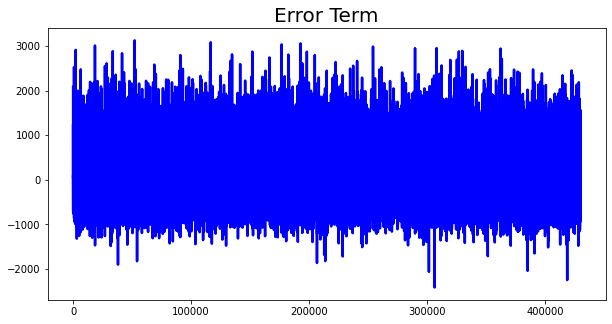

In [ ]:
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_dt_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error Term', fontsize=20)
plt.show()

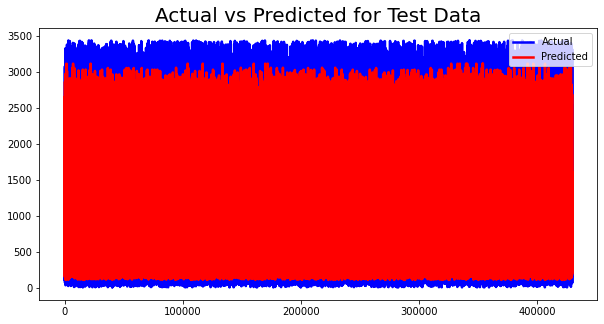

In [ ]:
#Actual vs Prediction
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='blue', linewidth=2.5, linestyle='-')
plt.plot(c, y_pred_dt_test, color='red', linewidth=2.5, linestyle='-')
plt.title('Actual vs Predicted for Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

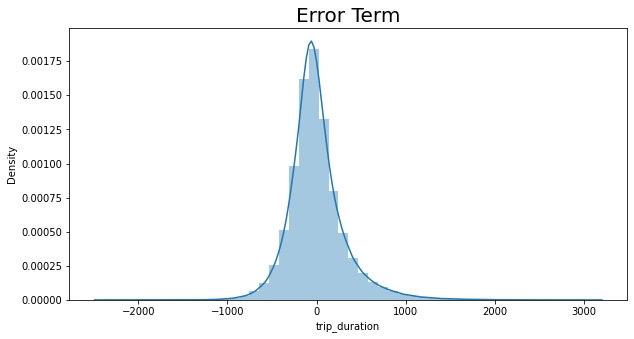

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(y_test - y_pred_dt_test )
plt.title('Error Term', fontsize=20)
plt.show()

The decision tree with the selected hyperparameters does improve the predictions of the model considerably. It still isn't ideal but it is certainly much better than Linear models.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Create the data of independent variables
X = df_corr[independent_variables]

# Create the dependent variable data
y = df_corr['trip_duration']

In [ ]:
#Importing RFE and Linear Regression 
from sklearn.model_selection import train_test_split

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
# Fitting Random Forest Regression to the dataset
# create regressor object
# regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
rforest = RandomForestRegressor(n_estimators = 20, n_jobs = -1)
# fit the regressor with x and y data
rforest.fit(X_train, y_train) 

RandomForestRegressor(n_estimators=20, n_jobs=-1)

In [ ]:
y_pred_dt_train = rforest.predict(X_train)
y_pred_dt_test = rforest.predict(X_test)

In [ ]:
dt_train_mse  = mean_squared_error(y_train, y_pred_dt_train)
print("Train MSE :" , dt_train_mse)

dt_train_r2 = r2_score(y_train, y_pred_dt_train)
print("Train R2 :" ,dt_train_r2)

dt_train_r2_= 1-(1-r2_score(y_train, y_pred_dt_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", dt_train_r2_)

Train MSE : 15719.509516460244
Train R2 : 0.9523175225049502
Train Adjusted R2 :  0.9523170945997267


In [ ]:
dt_test_mse  = mean_squared_error(y_test, y_pred_dt_test)
print("Test MSE :" , dt_test_mse)

dt_test_r2 = r2_score(y_test, y_pred_dt_test)
print("Test R2 :" ,dt_test_r2)

dt_test_r2_= 1-(1-r2_score(y_test, y_pred_dt_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", dt_test_r2_)

Test MSE : 99994.32053030956
Test R2 : 0.6978410472646264
Test Adjusted R2 :  0.6978347201381978


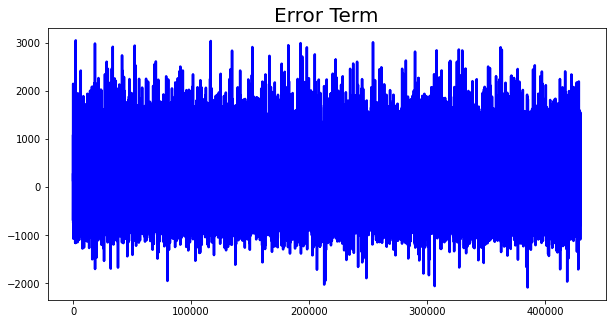

In [ ]:
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_dt_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error Term', fontsize=20)
plt.show()

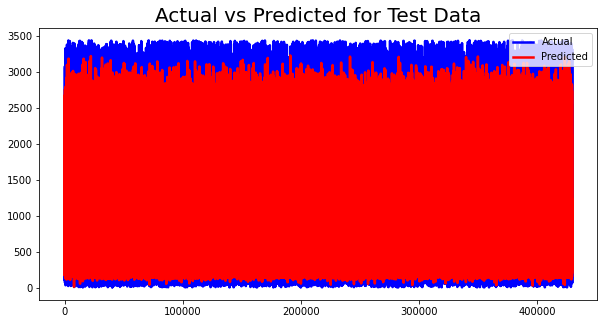

In [ ]:
#Actual vs Prediction
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='blue', linewidth=2.5, linestyle='-')
plt.plot(c, y_pred_dt_test, color='red', linewidth=2.5, linestyle='-')
plt.title('Actual vs Predicted for Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

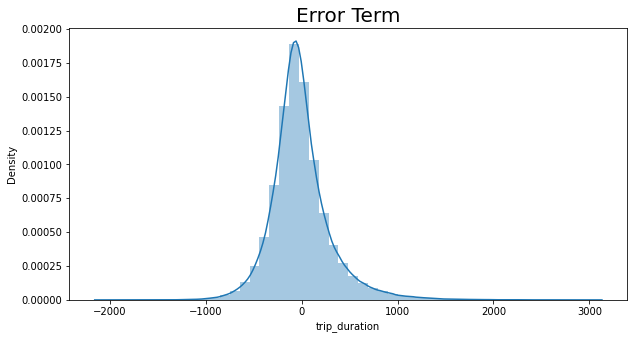

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(y_test - y_pred_dt_test )
plt.title('Error Term', fontsize=20)
plt.show()

In [ ]:
# def __init__(n_estimators=100, *, criterion='squared_error', 
#              max_depth=None, min_samples_split=2, min_samples_leaf=1,
#              min_weight_fraction_leaf=0.0, max_features='auto',
#              max_leaf_nodes=None, min_impurity_decrease=0.0, 
#              bootstrap=True, oob_score=False, n_jobs=None, 
#              random_state=None, verbose=0, warm_start=False, 
#              ccp_alpha=0.0, max_samples=None)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [5,10,15,20]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 5, 10]
# Method of selecting samples for training each tree
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }


In [ ]:
rf_reg = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf_reg, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state= 0, n_jobs = -1)

rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=0, verbose=2)

In [ ]:
rf_random.best_params_

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 15,
 'n_estimators': 500}

In [ ]:
y_pred_dt_train = rf_random.predict(X_train)
y_pred_dt_test = rf_random.predict(X_test)

In [ ]:
dt_train_mse  = mean_squared_error(y_train, y_pred_dt_train)
print("Train MSE :" , dt_train_mse)

dt_train_r2 = r2_score(y_train, y_pred_dt_train)
print("Train R2 :" ,dt_train_r2)

dt_train_r2_= 1-(1-r2_score(y_train, y_pred_dt_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", dt_train_r2_)

Train MSE : 65256.55786794846
Train R2 : 0.8020552518712717
Train Adjusted R2 :  0.8020534755040163


In [ ]:
dt_test_mse  = mean_squared_error(y_test, y_pred_dt_test)
print("Test MSE :" , dt_test_mse)

dt_test_r2 = r2_score(y_test, y_pred_dt_test)
print("Test R2 :" ,dt_test_r2)

dt_test_r2_= 1-(1-r2_score(y_test, y_pred_dt_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", dt_test_r2_)

Test MSE : 92803.35345074501
Test R2 : 0.7195704321976153
Test Adjusted R2 :  0.7195645600786074


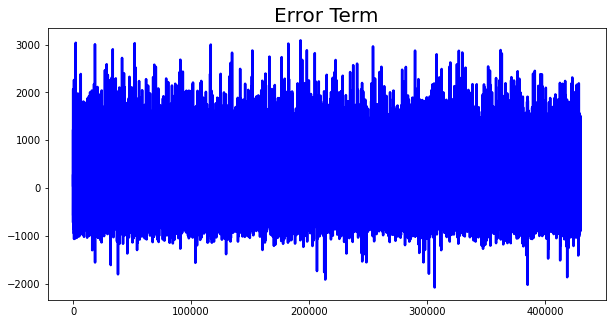

In [ ]:
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_dt_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error Term', fontsize=20)
plt.show()

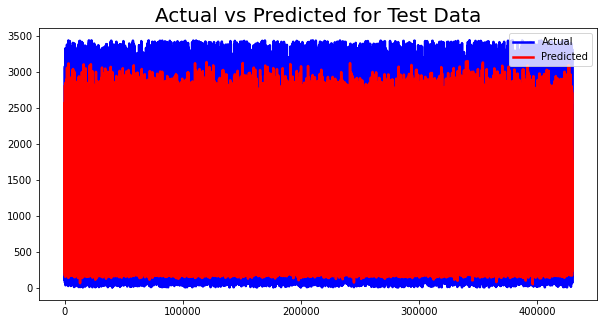

In [ ]:
#Actual vs Prediction
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='blue', linewidth=2.5, linestyle='-')
plt.plot(c, y_pred_dt_test, color='red', linewidth=2.5, linestyle='-')
plt.title('Actual vs Predicted for Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

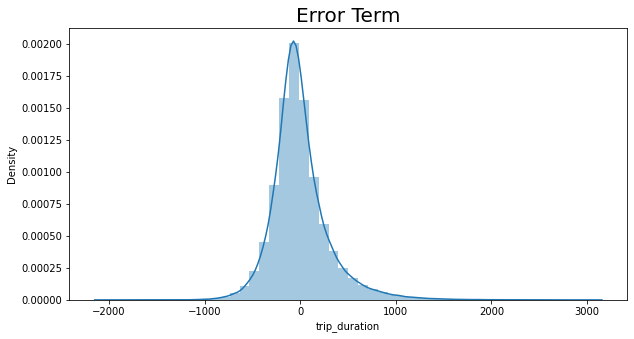

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(y_test - y_pred_dt_test )
plt.title('Error Term', fontsize=20)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_features':['auto', 'sqrt'],
    'max_depth': [10, 20, 40],
    'min_samples_leaf':[1,5,10],
    'n_estimators':[300, 500,1000]
    }
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

NameError: ignored

In [ ]:
grid_search.fit(X_train,y_train)

NameError: ignored

#<b>Running XGBoost Regressor

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [ ]:
# xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, 
# max_depth = 5, alpha = 10, n_estimators = 10)

In [ ]:
xgb_model = xgb.XGBRegressor(random_state=0, objective='reg:squarederror')

# set the hyperparameter for XGBRegressor
param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3,4],
        'subsample': [0.5, 0.7,0.75],
        'colsample_bytree': [0.5, 0.7,1],
        'n_estimators' : [100, 200,300,400],
        'gama':[0,1,2,3,4,5],
        'objective': ['reg:squarederror']
    }
#grid_values = {'n_estimators' : [200], 'max_depth': [8], 'min_samples_' : [40],'learning_rate' : [0.2]}
xgb_model = GridSearchCV(xgb_model, param_grid = param_tuning,scoring = 'r2', cv=5,verbose=1,)

In [ ]:
xgb_model.fit(X_train,y_train)

In [ ]:
print('The best fit alpha value is found out to be :' ,xgb_model.best_params_)
print('The R2 score using the same alpha is :', xgb_model.best_score_)

**The best parameters for the XGBoost which we already tested before to save time when running it again.**
* {'learning_rate': 0.2, 'max_depth': 8, 'min_samples_': 40, 'n_estimators': 200}

In [ ]:
xgb_model.best_params_

In [ ]:
xgb_model.best_score_

In [ ]:
y_pred_xgb_train=xgb_model.predict(X_train)
y_pred_xgb_test=xgb_model.predict(X_test)

#<b>Model Evaluation

In [ ]:
xgb_train_mse  = mean_squared_error(y_train, y_pred_xgb_train)
print("Train MSE :" , xgb_train_mse)

xgb_train_r2 = r2_score(y_train, y_pred_xgb_train)
print("Train R2 :" ,xgb_train_r2)

xgb_train_r2_= 1-(1-r2_score((y_train), (y_pred_xgb_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", xgb_train_r2_)

In [ ]:
xgb_test_mse  = mean_squared_error(y_test, y_pred_xgb_test)
print("Test MSE :" , xgb_test_mse)

xgb_test_r2 = r2_score(y_test, y_pred_xgb_test)
print("Test R2 :" ,xgb_test_r2)

xgb_test_r2_= 1-(1-r2_score((y_test), (y_pred_xgb_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", xgb_test_r2_)

In [ ]:
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_xgb_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error Term', fontsize=20)
plt.show()

In [ ]:
#Actual vs Prediction
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='blue', linewidth=2.5, linestyle='-')
plt.plot(c, y_pred_xgb_test, color='red', linewidth=2.5, linestyle='-')
plt.title('Actual vs Predicted for Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

Finally, let's also look the feature importance.

In [ ]:
importance_df= pd.DataFrame({'Features': features, 'Feature_importance': list(xgb_model.best_estimator_.feature_importances_)})
importance_df

In [ ]:
importance_df.sort_values(by=['Feature_importance'],ascending=False,inplace=True)

Let's look it by using bar grabh.

In [ ]:
plt.figure(figsize=(15,6))
plt.title('Feature Importance', fontsize=20)
sns.barplot(x='Features',y="Feature_importance", data=importance_df[:6])
plt.show()

Clearly, we can see distance is the top contributor to trip duration followed by different days of the weeks.

In [ ]:
#Plotting the error terms to understand the distribution.
plt.figure(figsize=(10,5))
sns.distplot(y_test - y_pred_xgb_test )
plt.title('Error Term', fontsize=20)
plt.show()

#<b>Evaluating the models
Models Summary for the Train data.

In [ ]:
models= ['Linear Regression', 'Lasso Regression', 'Ridge Regression','DecisionTree Regressor','XGBoost Regressor']
train_mse= [lr_train_mse, lasso_train_mse, ridge_train_mse, dt_train_mse, xgb_train_mse]
train_rmse= [lr_train_rmse, lasso_train_rmse, ridge_train_rmse, dt_train_rmse, xgb_train_rmse]
train_r2= [lr_train_r2, lasso_train_r2, ridge_train_r2, dt_train_r2, xgb_train_r2]
train_adjusted_r2= [lr_train_r2_, lasso_train_r2_, ridge_train_r2_, dt_train_r2_, xgb_train_r2_]

<b>Models Summary for the test data.

In [ ]:
models= ['Linear Regression', 'Lasso Regression', 'Ridge Regression','DecisionTree Regressor','XGBoost Regressor']
test_mse= [lr_test_mse, lasso_test_mse, ridge_test_mse, dt_test_mse, xgb_test_mse]
test_rmse= [lr_test_rmse, lasso_test_rmse, ridge_test_rmse, dt_test_rmse, xgb_test_rmse]
test_r2= [lr_test_r2, lasso_test_r2, ridge_test_r2, dt_test_r2, xgb_test_r2]
test_adjusted_r2= [lr_test_r2_, lasso_test_r2_, ridge_test_r2_, dt_test_r2_, xgb_test_r2_]

In [ ]:
Train_data_df=pd.DataFrame({'Model Name': models, 'Train MSE': train_mse, 'Train RMSE': train_rmse, 'Train R^2': train_r2, 
                            'Train Adjusted R^2': train_adjusted_r2})
Train_data_df

In [ ]:
Test_data_df= pd.DataFrame({'Model Name': models, 'Test MSE': test_mse, 'Test RMSE': test_rmse, 'Test R^2': test_r2, 
                            'Test Adjusted R^2': test_adjusted_r2})
Test_data_df

#**Conclusion**
* We can see that MSE and RMSE which are the metrics used to evaluate the performance of regression model of **Decision Tree** and **XGBoost Regressor** is not varying much during traing and testing time. Also the R^2 is about same during training and Testing time.
* The Linear models don't show good performance on our training and testing environment.
* From above table we can conclude that **XGBoost Regressor** is the best models as compare to the other models to predict the trip duration for a particular taxi.